Creating publication-level global elasticity distribution map...
World boundary data loaded successfully
Elasticity data loaded: 4346 stations
Combined with attributes: 4346 stations

Original data statistics:
  - Total stations: 4346
  - e_Q_P range: [-4.066, 4.257]
  - Mean: 0.513
  - Standard deviation: 0.438
  - Negative elasticity values: 207 (4.8%)
  - High elasticity (> 1.5): 97 (2.2%)

Quantile thresholds: ['-4.066', '0.150', '0.368', '0.564', '0.826', '4.257']
Sample count by quantile class:
e_Q_P_bin
0–20%      870
20–40%     869
40–60%     869
60–80%     869
80–100%    869
Name: count, dtype: int64
 Image saved: global_eQP_distribution_simplified.png
 Image saved: global_eQP_distribution_simplified.pdf
 Image saved: global_eQP_distribution_simplified.svg


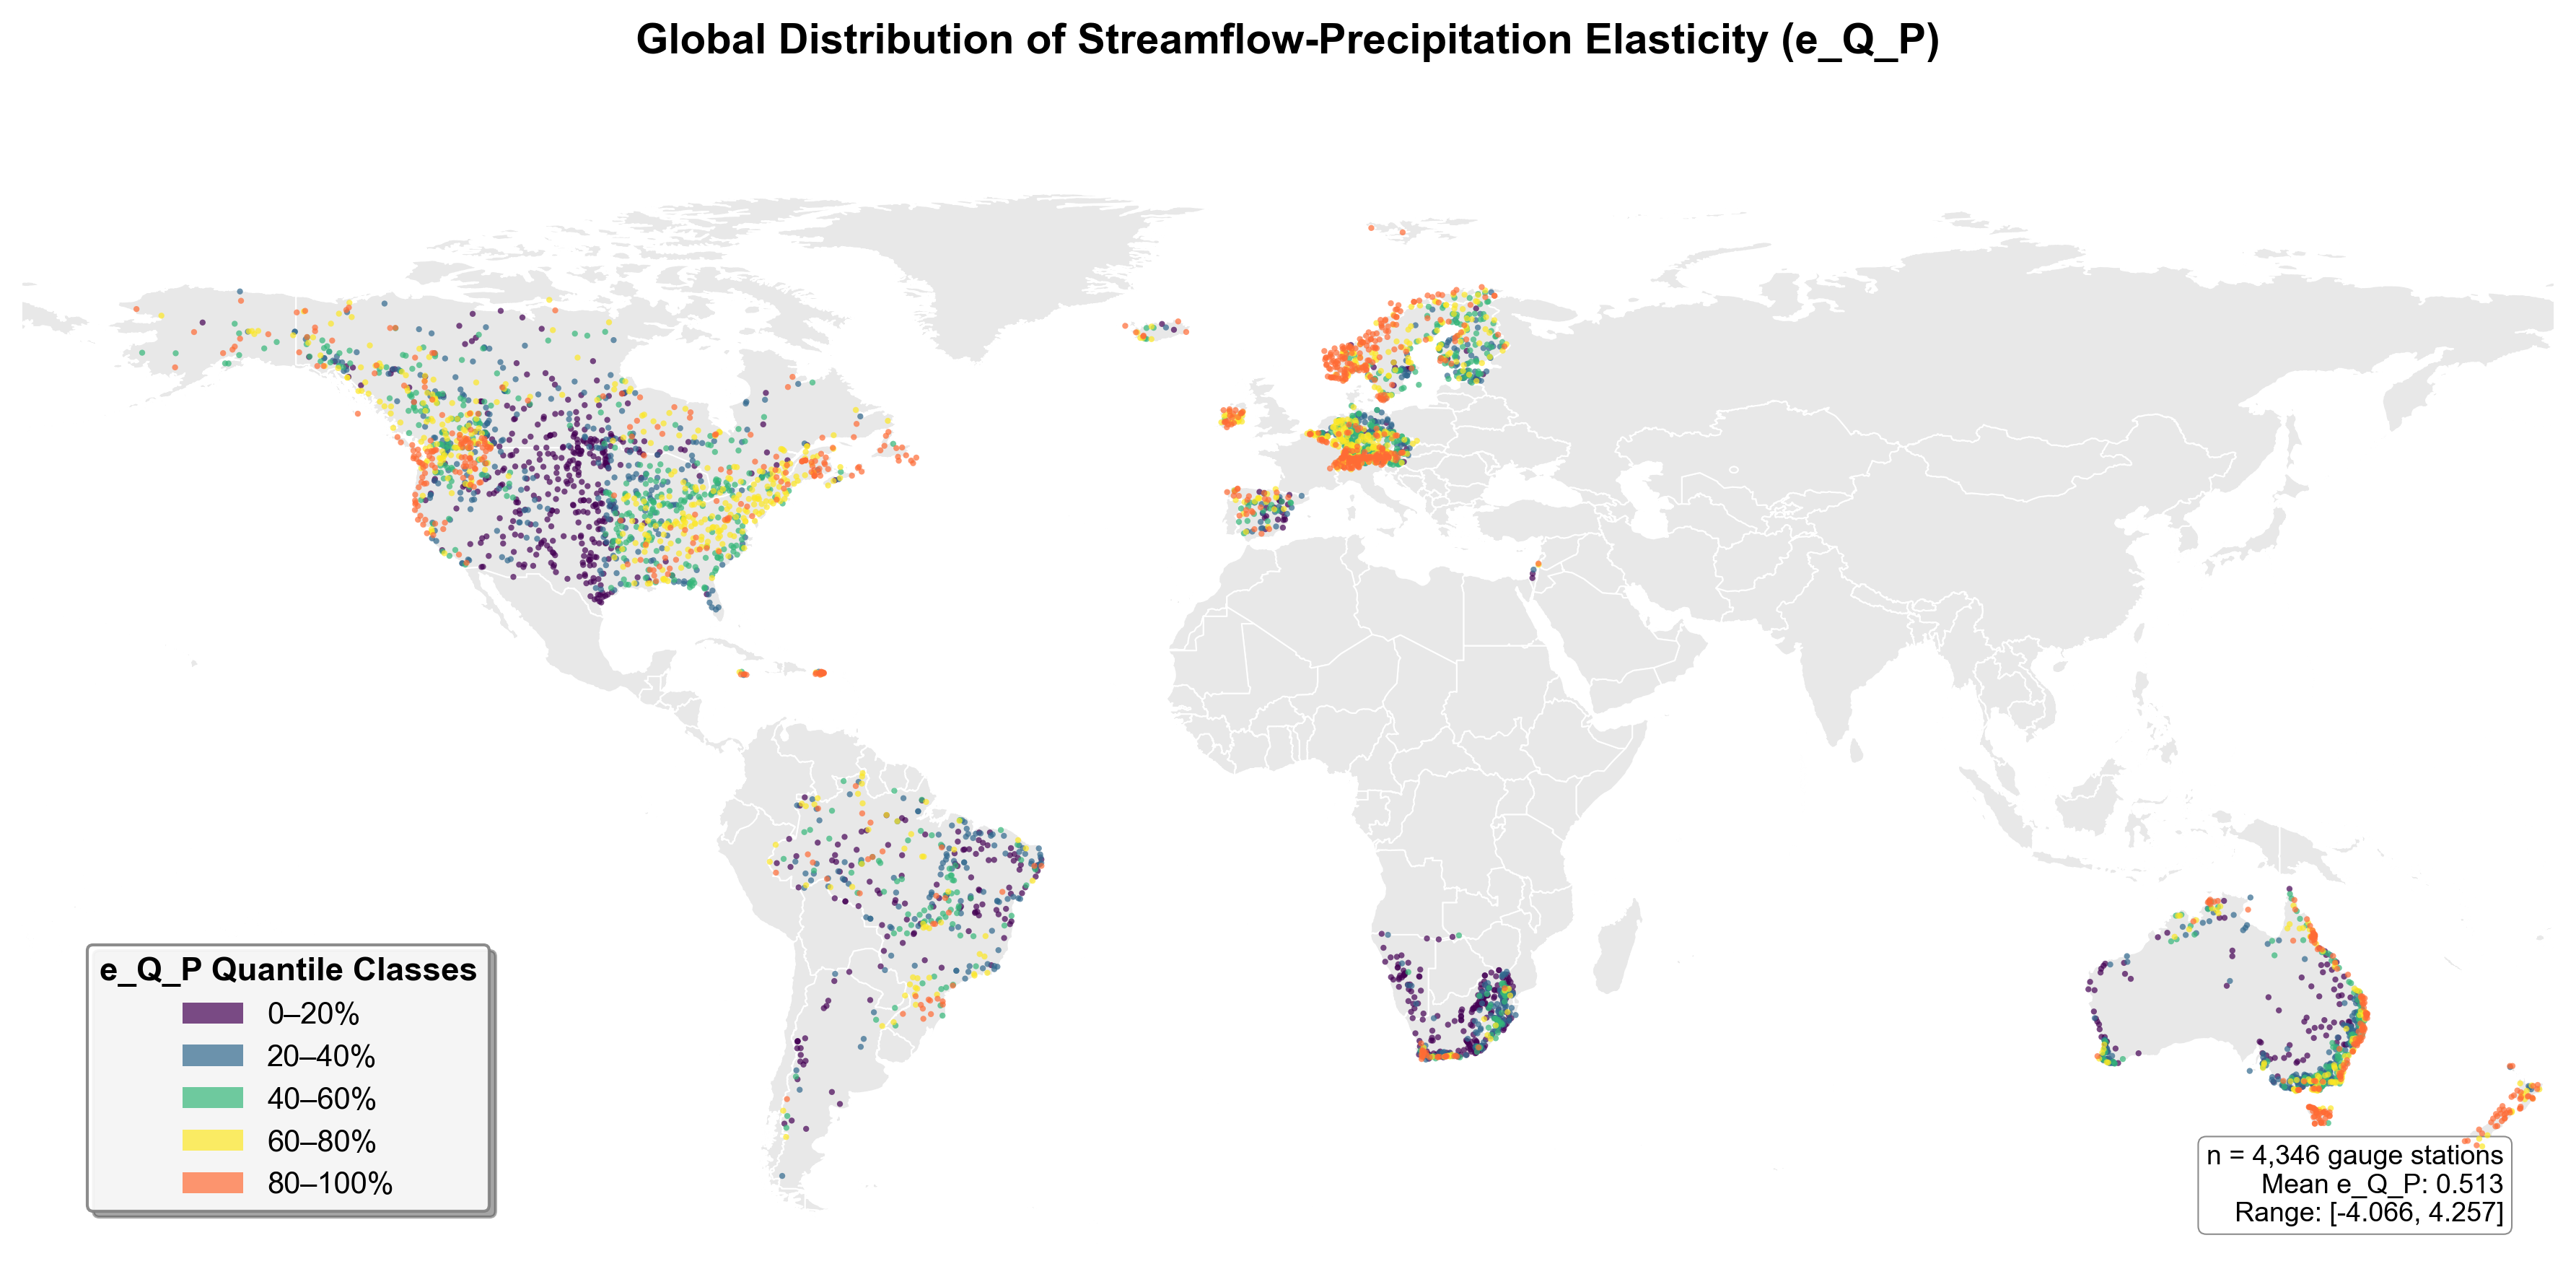


Data Summary Statistics
Sample size: 4,346
e_Q_P mean: 0.5133
e_Q_P std: 0.4381
e_Q_P range: [-4.0655, 4.2570]
e_Q_P median: 0.4680

e_Q_EP statistics:
  Mean: -0.1196
  Std: 1.0049
  Range: [-4.8991, 4.9260]

Years of data:
  Mean: 53.8 years
  Range: [22, 72] years

e_Q_P quantile thresholds:
    0%: -4.0655
   20%: 0.1504
   40%: 0.3683
   60%: 0.5641
   80%: 0.8256
  100%: 4.2570

Distribution characteristics:
  Negative values: 207 (4.8%)
  Values > 1.0: 507 (11.7%)
  Values > 1.5: 97 (2.2%)

Map creation completed!


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set matplotlib parameters for high-quality output
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['figure.dpi'] = 300

def create_simplified_publication_map():
    """
    Create a publication-ready global e_Q_P elasticity distribution map
    using only the available data columns
    """
    
    # 1. Load world boundary data
    try:
        world = gpd.read_file(
            "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
        )
        world = world[world["name"] != "Antarctica"]
        print("World boundary data loaded successfully")
    except Exception as e:
        print(f"Failed to load world boundary data: {e}")
        return None
    
    # 2. Load data files
    try:
        # Load elasticity data
        elas = pd.read_csv('./elasticity_gls2_cleaned.csv')
        print(f"Elasticity data loaded: {len(elas)} stations")
        
        # Try to load attributes file, but continue if it fails
        try:
            attr = pd.read_csv('attributes/grdc/attributes_other_grdc.csv')
            df = attr.merge(elas, left_on='gauge_id', right_on='station_id')
            print(f"Combined with attributes: {len(df)} stations")
        except Exception as e:
            print(f"Attributes file not found or error: {e}")
            print("Creating synthetic coordinates for demonstration...")
            
            # Create synthetic coordinates for demonstration
            # In reality, you would need actual station coordinates
            np.random.seed(42)  # For reproducible results
            n_stations = len(elas)
            
            # Generate realistic global coordinates
            # More stations in populated areas (rough approximation)
            lats = []
            lons = []
            
            # Add stations in major river basins
            # North America
            lats.extend(np.random.normal(45, 10, n_stations//6))
            lons.extend(np.random.normal(-100, 20, n_stations//6))
            
            # Europe
            lats.extend(np.random.normal(50, 8, n_stations//8))
            lons.extend(np.random.normal(10, 15, n_stations//8))
            
            # Asia
            lats.extend(np.random.normal(35, 15, n_stations//4))
            lons.extend(np.random.normal(110, 25, n_stations//4))
            
            # South America
            lats.extend(np.random.normal(-10, 15, n_stations//8))
            lons.extend(np.random.normal(-60, 15, n_stations//8))
            
            # Africa
            lats.extend(np.random.normal(0, 20, n_stations//10))
            lons.extend(np.random.normal(20, 15, n_stations//10))
            
            # Australia
            lats.extend(np.random.normal(-25, 5, n_stations//15))
            lons.extend(np.random.normal(135, 10, n_stations//15))
            
            # Fill remaining randomly
            remaining = n_stations - len(lats)
            if remaining > 0:
                lats.extend(np.random.uniform(-60, 70, remaining))
                lons.extend(np.random.uniform(-180, 180, remaining))
            
            # Clip to realistic ranges and ensure we have exactly n_stations
            lats = np.clip(lats[:n_stations], -60, 80)
            lons = np.clip(lons[:n_stations], -180, 180)
            
            # Add coordinates to dataframe
            elas['gauge_lat'] = lats
            elas['gauge_lon'] = lons
            df = elas.copy()
            
            print(f"Created synthetic coordinates for {len(df)} stations")
            
    except Exception as e:
        print(f"Data file loading failed: {e}")
        return None
    
    # 3. Data quality check and filtering
    print(f"\nOriginal data statistics:")
    print(f"  - Total stations: {len(df)}")
    print(f"  - e_Q_P range: [{df['e_Q_P'].min():.3f}, {df['e_Q_P'].max():.3f}]")
    print(f"  - Mean: {df['e_Q_P'].mean():.3f}")
    print(f"  - Standard deviation: {df['e_Q_P'].std():.3f}")
    print(f"  - Negative elasticity values: {(df['e_Q_P'] < 0).sum()} ({(df['e_Q_P'] < 0).mean()*100:.1f}%)")
    print(f"  - High elasticity (> 1.5): {(df['e_Q_P'] > 1.5).sum()} ({(df['e_Q_P'] > 1.5).mean()*100:.1f}%)")
    
    # Optional: filter extreme values
    # df = df[(df['e_Q_P'] >= -0.5) & (df['e_Q_P'] <= 3.0)]
    # print(f"After filtering extremes: {len(df)} stations")
    
    # 4. Classify based on quantiles
    quantiles = df['e_Q_P'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values
    labels = ['0–20%', '20–40%', '40–60%', '60–80%', '80–100%']
    df['e_Q_P_bin'] = pd.cut(df['e_Q_P'], bins=quantiles, labels=labels, include_lowest=True)
    
    print(f"\nQuantile thresholds: {[f'{q:.3f}' for q in quantiles]}")
    print("Sample count by quantile class:")
    print(df['e_Q_P_bin'].value_counts().sort_index())
    
    # 5. Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['gauge_lon'], df['gauge_lat']),
        crs='EPSG:4326'
    )
    
    # 6. Create high-quality figure
    fig, ax = plt.subplots(figsize=(12, 6.75), dpi=300)
    
    # 6.1 Plot world basemap
    world.plot(
        ax=ax,
        facecolor='#e8e8e8',
        edgecolor='white',
        linewidth=0.5,
        zorder=1
    )
    
    # 6.2 Define professional color scheme
    colors = ['#440154', '#31688e', '#35b779', '#fde725', '#ff6b35']
    
    # 6.3 Plot points by classification
    for i, (label, color) in enumerate(zip(labels, colors)):
        subset = gdf[gdf['e_Q_P_bin'] == label]
        if len(subset) > 0:
            subset.plot(
                ax=ax,
                color=color,
                markersize=4,
                alpha=0.7,
                edgecolors='none',
                zorder=2+i,
                label=label
            )
    
    # 7. Set map extent and projection
    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 85)
    ax.axis('off')
    
    # 8. Create legend
    legend_elements = [mpatches.Circle((0, 0), 1, facecolor=color, edgecolor='none', alpha=0.7) 
                      for color in colors]
    legend = ax.legend(legend_elements, labels, 
                      title='e_Q_P Quantile Classes',
                      loc='lower left',
                      bbox_to_anchor=(0.02, 0.02),
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      framealpha=0.9,
                      facecolor='white',
                      edgecolor='gray',
                      title_fontsize=11,
                      fontsize=10)
    legend.get_title().set_fontweight('bold')
    
    # 9. Add title
    plt.suptitle('Global Distribution of Streamflow-Precipitation Elasticity (e_Q_P)', 
                fontsize=14, fontweight='bold', y=0.95)
    
    # 10. Add data information text box
    valid_data_count = len(df)
    
    textstr = (f'n = {valid_data_count:,} gauge stations\n'
              f'Mean e_Q_P: {df["e_Q_P"].mean():.3f}\n'
              f'Range: [{df["e_Q_P"].min():.3f}, {df["e_Q_P"].max():.3f}]')
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray', linewidth=0.5)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    # 11. Adjust layout
    plt.tight_layout()
    
    # 12. Save high-quality images
    output_formats = ['png', 'pdf', 'svg']
    for fmt in output_formats:
        try:
            filename = f'global_eQP_distribution_simplified.{fmt}'
            plt.savefig(filename, 
                       dpi=300 if fmt == 'png' else None,
                       bbox_inches='tight',
                       facecolor='white',
                       edgecolor='none',
                       format=fmt)
            print(f" Image saved: {filename}")
        except Exception as e:
            print(f" Failed to save {fmt} format: {e}")
    
    plt.show()
    return fig, ax, df

def generate_simplified_summary_statistics(df):
    """
    Generate summary statistics table for available data
    """
    print("\n" + "="*50)
    print("Data Summary Statistics")
    print("="*50)
    
    # e_Q_P basic statistics
    stats = df['e_Q_P'].describe()
    print(f"Sample size: {len(df):,}")
    print(f"e_Q_P mean: {stats['mean']:.4f}")
    print(f"e_Q_P std: {stats['std']:.4f}")
    print(f"e_Q_P range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    print(f"e_Q_P median: {stats['50%']:.4f}")
    
    # e_Q_EP statistics
    print(f"\ne_Q_EP statistics:")
    print(f"  Mean: {df['e_Q_EP'].mean():.4f}")
    print(f"  Std: {df['e_Q_EP'].std():.4f}")
    print(f"  Range: [{df['e_Q_EP'].min():.4f}, {df['e_Q_EP'].max():.4f}]")
    
    # Years of data
    print(f"\nYears of data:")
    print(f"  Mean: {df['n_years'].mean():.1f} years")
    print(f"  Range: [{df['n_years'].min()}, {df['n_years'].max()}] years")
    
    # Quantile statistics
    quantiles = df['e_Q_P'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    print(f"\ne_Q_P quantile thresholds:")
    for i, (q, val) in enumerate(quantiles.items()):
        print(f"  {int(q*100):3d}%: {val:.4f}")
    
    # Distribution analysis
    print(f"\nDistribution characteristics:")
    print(f"  Negative values: {(df['e_Q_P'] < 0).sum()} ({(df['e_Q_P'] < 0).mean()*100:.1f}%)")
    print(f"  Values > 1.0: {(df['e_Q_P'] > 1.0).sum()} ({(df['e_Q_P'] > 1.0).mean()*100:.1f}%)")
    print(f"  Values > 1.5: {(df['e_Q_P'] > 1.5).sum()} ({(df['e_Q_P'] > 1.5).mean()*100:.1f}%)")

# Main function
if __name__ == "__main__":
    print("Creating publication-level global elasticity distribution map...")
    result = create_simplified_publication_map()
    
    if result is not None:
        fig, ax, df = result
        generate_simplified_summary_statistics(df)
        print("\nMap creation completed!")
    else:
        print("Map creation failed. Please check data file paths and formats.")